In [16]:
import pandas as pd
import os
from pathlib import Path

DATA_PATH = Path("../data/raw/suicide.csv")
df = pd.read_csv(DATA_PATH)


print("===== Dimensiones del dataset =====")
print(df.shape)

print("\n===== Primeras filas =====")
print(df.head())

print("\n===== Info del dataset =====")
print(df.info())

print("\n===== Valores nulos por columna =====")
print(df.isnull().sum())

print("\n===== Valores únicos por columna =====")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} únicos")
    
print("\n===== Min y max year =====")
print(df['year'].min(), df['year'].max())


===== Dimensiones del dataset =====
(43776, 6)

===== Primeras filas =====
   country  year     sex          age  suicides_no  population
0  Albania  1985  female  15-24 years          NaN    277900.0
1  Albania  1985  female  25-34 years          NaN    246800.0
2  Albania  1985  female  35-54 years          NaN    267500.0
3  Albania  1985  female   5-14 years          NaN    298300.0
4  Albania  1985  female  55-74 years          NaN    138700.0

===== Info del dataset =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43776 entries, 0 to 43775
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      43776 non-null  object 
 1   year         43776 non-null  int64  
 2   sex          43776 non-null  object 
 3   age          43776 non-null  object 
 4   suicides_no  41520 non-null  float64
 5   population   38316 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 2.0+ MB
None

=====

El dataset tiene una buena cobertura espacial (141 países) y temporal (1979–2016), lo que lo hace muy útil para estudiar tendencias de largo plazo y diferencias por sexo y edad.
Se detectan valores nulos en suicides_no y population, lo cual refleja ausencia de datos en algunos contextos. Para un análisis inicial, conviene excluir esas filas al calcular tasas estandarizadas.
Antes de continuar, es necesario normalizar tipos de datos (convertir country, sex y age a categorías; y pasar suicides_no y population a enteros con soporte de nulos).

## Gráficas para entender un poco mejor el contexto de los datos.

### Evolución global de suicidios

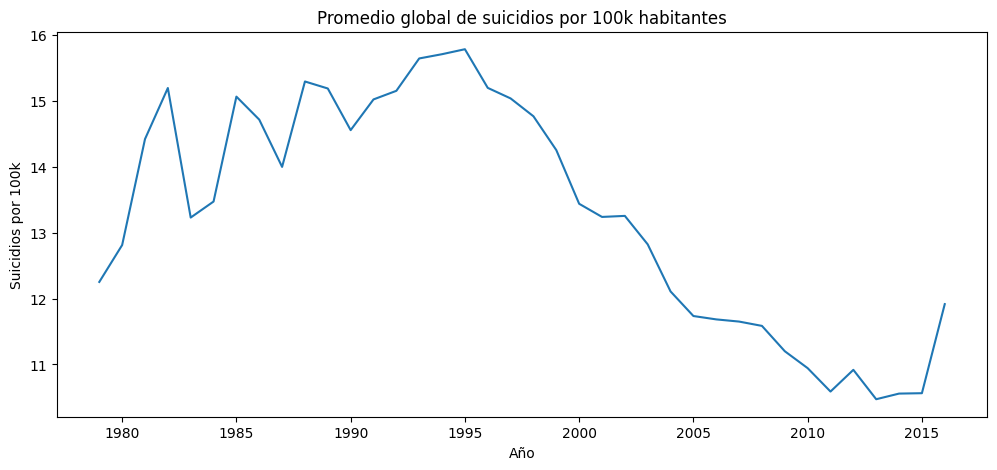

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear tasa estandarizada
df['suicides_rate'] = (df['suicides_no'] / df['population'] * 100000)

# Quitar filas con nulos
df_clean = df.dropna(subset=['suicides_no', 'population']).copy()

# Evolución global
global_trend = df_clean.groupby("year")['suicides_rate'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=global_trend, x="year", y="suicides_rate")
plt.title("Promedio global de suicidios por 100k habitantes")
plt.ylabel("Suicidios por 100k")
plt.xlabel("Año")
plt.show()


* Se observa un aumento sostenido desde 1980 hasta mediados de los 90.
* A partir de ahí, hay una tendencia descendente bastante marcada desde 2000 en adelante.
* El mínimo histórico se da alrededor de 2012–2014.
* En los últimos años (2015–2016) parece haber un ligero repunte, que conviene investigar si es real o ruido en los datos.

### Diferencias por género

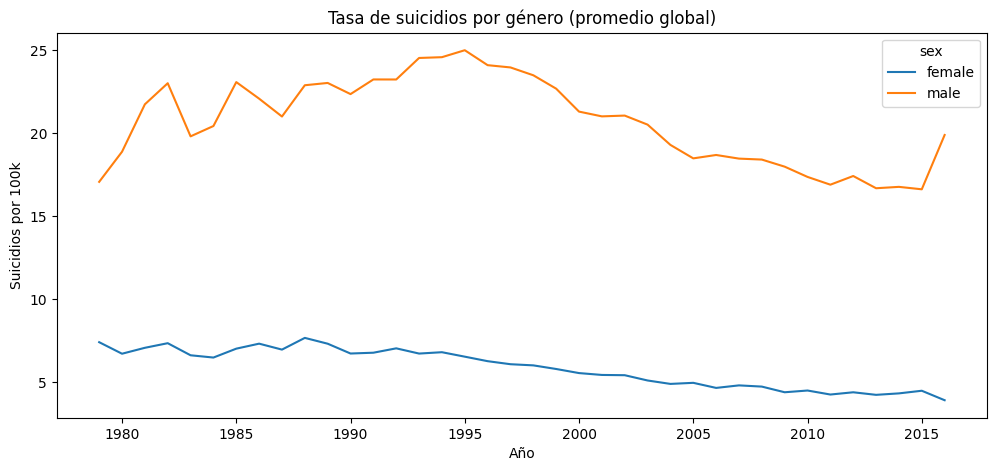

In [18]:
gender_trend = df_clean.groupby(["year","sex"])['suicides_rate'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=gender_trend, x="year", y="suicides_rate", hue="sex")
plt.title("Tasa de suicidios por género (promedio global)")
plt.ylabel("Suicidios por 100k")
plt.xlabel("Año")
plt.show()


* Claramente, la tasa de suicidios en hombres es 3–5 veces mayor que en mujeres.
* En mujeres, la curva es más estable y baja, con tasas promedio entre 4–7 por 100k.
* En hombres, el pico fue en los 90 con valores cercanos a 25 por 100k, y luego se observa una disminución.
* Esto confirma la literatura: el suicidio es un fenómeno con alta disparidad de género.

### Diferencia por grupo de edad

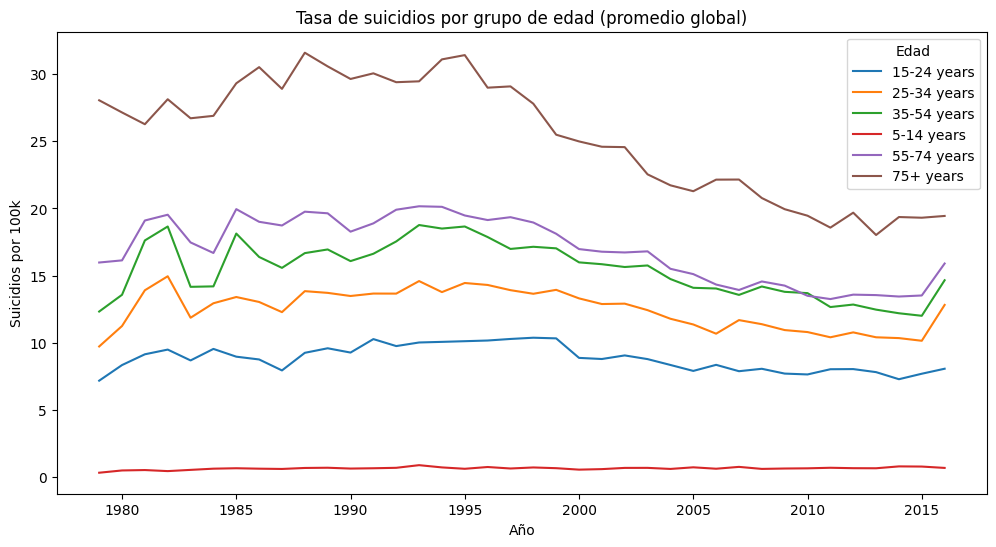

In [19]:
age_trend = df_clean.groupby(["year","age"])['suicides_rate'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=age_trend, x="year", y="suicides_rate", hue="age")
plt.title("Tasa de suicidios por grupo de edad (promedio global)")
plt.ylabel("Suicidios por 100k")
plt.xlabel("Año")
plt.legend(title="Edad")
plt.show()




* Los grupos de mayor riesgo son:

  * **75+ años** (la tasa más alta en todo el periodo, llegando a 30 por 100k).
  * **35–74 años**, con valores entre 15–20 por 100k.
* Grupos intermedios (25–34) mantienen tasas relevantes pero menores.
* Jóvenes (15–24) tienen una tasa bastante más baja (\~10 por 100k), y el grupo **5–14 años casi inexistente** (como era esperable).
* Esto muestra que el suicidio es un problema especialmente crítico en **adultos mayores**.


### Análisis de valores nulos

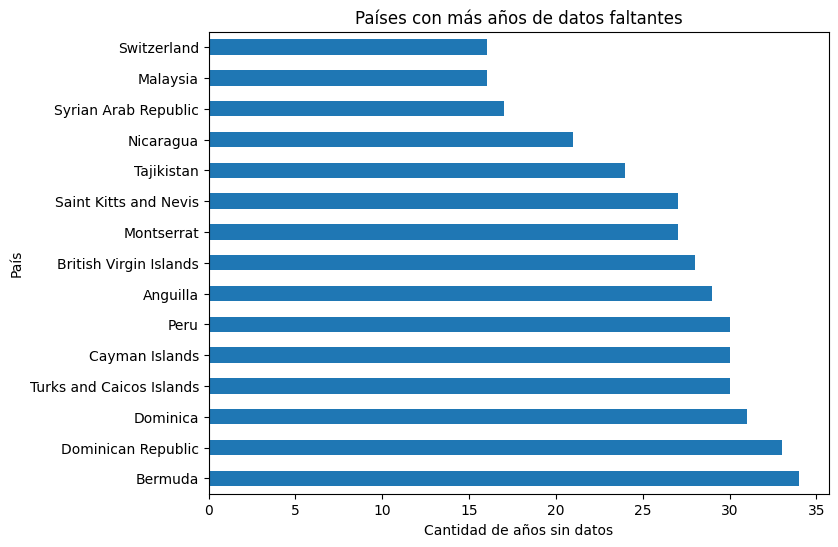

In [20]:
null_summary = df[df['population'].isna() | df['suicides_no'].isna()]
missing_by_country = null_summary.groupby("country")['year'].nunique().sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
missing_by_country.plot(kind="barh")
plt.title("Países con más años de datos faltantes")
plt.xlabel("Cantidad de años sin datos")
plt.ylabel("País")
plt.show()




* Hay países con **muchísimos años sin datos**: Bermudas, República Dominicana, Dominica, islas del Caribe, y varios pequeños territorios.
* Algunos países grandes como **Perú** también presentan huecos de más de 20 años.
* Esto significa que el análisis global puede estar sesgado hacia países con mejor sistema de reporte.



### Mapa coroplético por año

In [ ]:
# Mapa coroplético de tasas de suicidio por país y año
import plotly.express as px

# 1. Calcular la tasa por 100k hab
# Ordenar por año
df = df.sort_values(by="year")
df["suicides_per_100k"] = (df["suicides_no"] / df["population"]) * 100000

# 2. Mapa coroplético por año
fig = px.choropleth(
    df,
    locations="country",          # columna con países
    locationmode="country names", # importante: usar nombres estándar
    color="suicides_per_100k",    # variable a colorear
    hover_name="country",         
    animation_frame="year",       # slider temporal
    color_continuous_scale="Reds",
    title="Tasa de suicidios por país y año"
)

fig.show()


### Mapa promedio por país

In [26]:
# --- 1) Preparación ---
# Asegurar tipos y tasa
df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["suicides_rate"] = (df["suicides_no"] / df["population"]) * 100000

# Filtrar rango confiable y filas válidas (sin nulos y población > 0)
dfm = (df[(df["year"] >= 1979) & (df["year"] <= 2016)]
         .dropna(subset=["suicides_no", "population", "suicides_rate"]))
dfm = dfm[dfm["population"] > 0].copy()

# --- 2) Agregación: promedio por país ---
avg_country = (dfm.groupby("country", as_index=False)
                  .agg(suicides_rate_mean=("suicides_rate", "mean"),
                       years_count=("year", "nunique")))

# --- 3) Mapa coroplético (promedio por país) ---
fig = px.choropleth(
    avg_country,
    locations="country",
    locationmode="country names",
    color="suicides_rate_mean",
    hover_name="country",
    hover_data={"suicides_rate_mean":":.2f", "years_count": True},
    color_continuous_scale="Reds",
    title="Tasa promedio de suicidios por 100k hab. (1979–2016)"
)
fig.update_layout(coloraxis_colorbar=dict(title="Suicidios / 100k"))

# Mostrar
fig.show()





1. **Liderazgo de Europa del Este y Rusia**
   * Europa del Este lidera encabeza con una tasa promedio de más de **35,21 suicidios por 100k habitantes**, lo cual es un número muy elevado.

2. **Latinoamérica: contraste entre países**

   * **Argentina**: alrededor de 10,53 suicidios por 100k.
   * **Uruguay**: casi el doble de Argentina (**18,72 por 100k**).
   * **Brasil**: valores mucho más bajos (**5,68 por 100k**).
    Esto muestra que dentro de la región hay **grandes disparidades**.

3. **Tasa baja en África**

   * Países como Sudáfrica apenas alcanzan **0,96 por 100k**, el valor más bajo.
   * Esto puede ser reflejo de **problemas de sub-reporte** en muchos países africanos y del Caribe, más que de una verdadera ausencia de casos.

4. **Reflexión general**

   * El mapa global revela que el suicidio tiene un **componente geográfico muy fuerte**:

     * Tasas altas en Europa del Este y parte de Asia.
     * Tasas medias en América Latina y algunos países de Occidente.
     * Tasas bajas en África y el Caribe, probablemente afectadas por la falta de datos.




### Top 10 países con mayor tasa promedio y Bottom 10 con menor tasa promedio

=====  Top 10 países con mayor tasa promedio (1979–2016) =====


,country,suicides_rate_mean,years_count
47,Hungary,39.675270,38
60,Lithuania,38.800886,34
101,Sri Lanka,37.782507,16
88,Russian Federation,35.205239,34
59,Latvia,32.479881,36
98,Slovenia,31.013602,31
34,Estonia,30.628150,33
55,Kazakhstan,30.219078,33
11,Belarus,29.479795,28
110,Ukraine,26.652677,32



=====  Bottom 10 países con menor tasa promedio (1979–2016) =====


,country,suicides_rate_mean,years_count
21,Cayman Islands,0.000000,1
89,Saint Kitts and Nevis,0.000000,3
32,Egypt,0.100537,18
53,Jamaica,0.439315,22
1,Antigua and Barbuda,0.533155,28
75,Oman,0.735743,3
99,South Africa,0.964471,20
57,Kuwait,1.055885,31
30,Dominica,1.121180,6
111,United Arab Emirates,1.317943,6


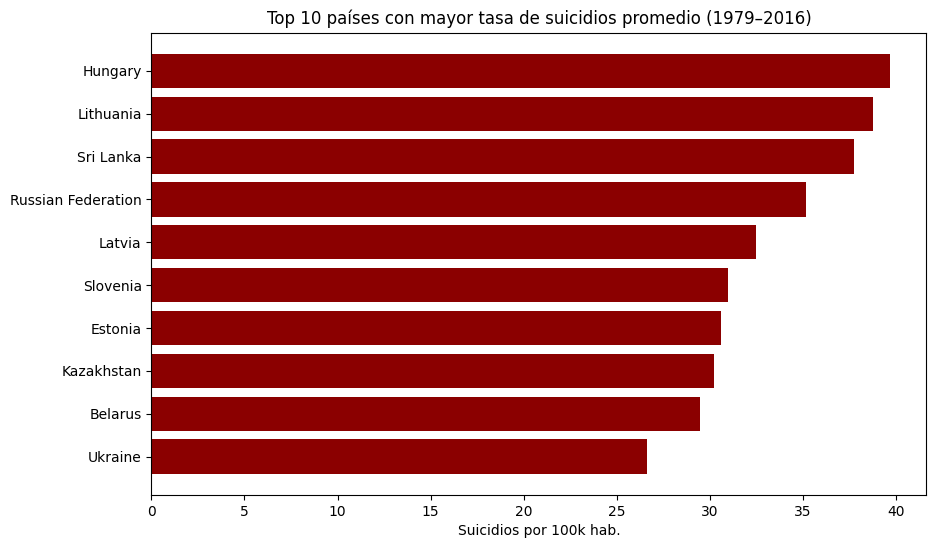

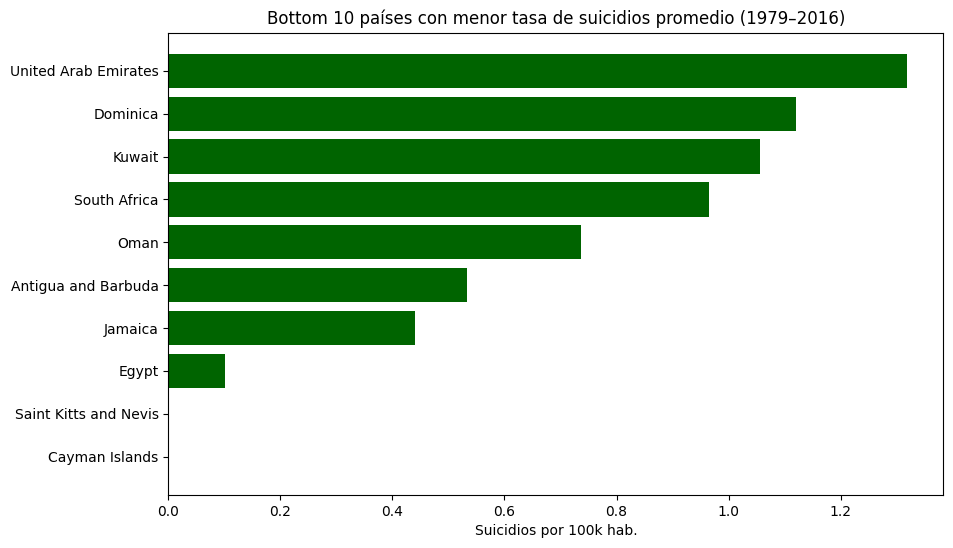

In [29]:
# --- 1) Ranking de países (promedio suicidios/100k 1979–2016) ---
# Ordenar de mayor a menor
top10 = avg_country.sort_values("suicides_rate_mean", ascending=False).head(10)
bottom10 = avg_country.sort_values("suicides_rate_mean", ascending=True).head(10)

# --- 2) Mostrar como tablas ---
print("=====  Top 10 países con mayor tasa promedio (1979–2016) =====")
display(top10[["country", "suicides_rate_mean", "years_count"]])

print("\n=====  Bottom 10 países con menor tasa promedio (1979–2016) =====")
display(bottom10[["country", "suicides_rate_mean", "years_count"]])

# --- 3) Gráficos tipo barras para visualizar ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.barh(top10["country"], top10["suicides_rate_mean"], color="darkred")
plt.gca().invert_yaxis()  # el país con más arriba
plt.title("Top 10 países con mayor tasa de suicidios promedio (1979–2016)")
plt.xlabel("Suicidios por 100k hab.")
plt.show()

plt.figure(figsize=(10,6))
plt.barh(bottom10["country"], bottom10["suicides_rate_mean"], color="darkgreen")
plt.title("Bottom 10 países con menor tasa de suicidios promedio (1979–2016)")
plt.xlabel("Suicidios por 100k hab.")
plt.show()




1. **Top 10 países con mayor tasa promedio (1979–2016)**

   * Se confirma que los países con mayor tasa histórica de suicidios son **Europa del Este** (Hungría, Lituania, Rusia, Letonia, Eslovenia, Estonia, Bielorrusia, Ucrania, Kazajistán).
   * Aparece también **Sri Lanka**, que históricamente ha tenido problemas con altas tasas de suicidio por intoxicación con pesticidas.
   * Las tasas promedio superan los **30–40 suicidios por 100k**, más del doble del promedio global.

2. **Bottom 10 países con menor tasa promedio**

   * Incluye naciones de **África (Sudáfrica, Egipto)**, el **Caribe (Dominica, Jamaica, Antigua and Barbuda, Saint Kitts and Nevis, Islas Caimán)** y países del **Golfo (Emiratos Árabes, Kuwait, Omán)**.
   * Los valores están por debajo de **1,5 por 100k**, que parecen **irrealmente bajos** comparados con estudios epidemiológicos globales.
   * Esto podria decirnos que **pueden reflejar falta de reporte o baja calidad de los datos**, más que una verdadera ausencia del problema.

3. **Conclusión de los rankings**

   * El suicidio es un fenómeno **concentrado en regiones específicas (Europa del Este, Sri Lanka)**.
   * Los valores extremadamente bajos de algunos países son probablemente consecuencia de **limitaciones en la recolección de datos** y no deben interpretarse literalmente.
   * Esto refuerza la necesidad de analizar no solo tasas, sino también **calidad y cobertura del dataset**.




### Gráfico de evolución comparada entre países representativos

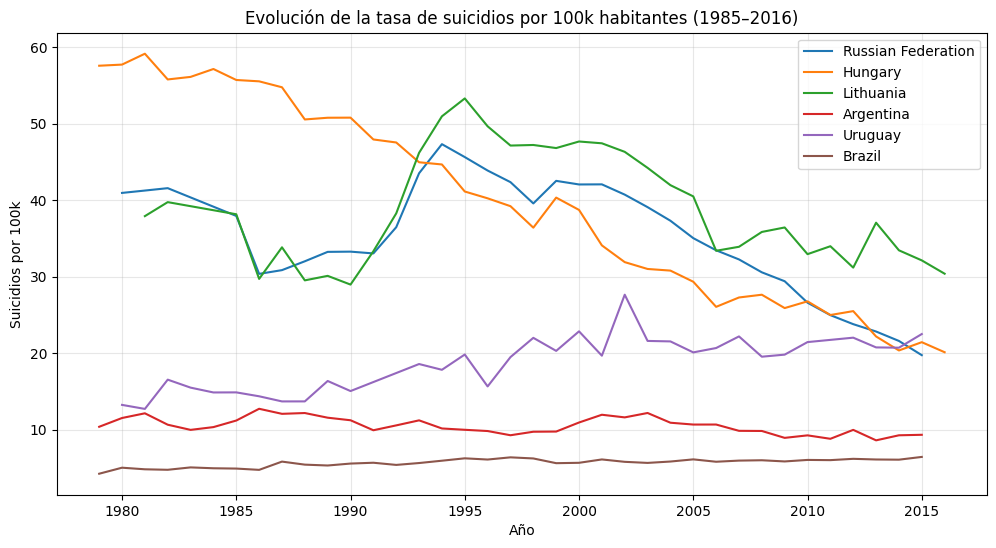

In [30]:

# --- 1) Selección de países representativos ---
paises = ["Russian Federation", "Hungary", "Lithuania", "Argentina", "Uruguay", "Brazil"]

# --- 2) Filtrar dataset ---
df_sel = dfm[dfm["country"].isin(paises)].copy()

# --- 3) Calcular promedio por país-año ---
trend = (df_sel.groupby(["year", "country"])["suicides_rate"]
               .mean()
               .reset_index())

# --- 4) Gráfico de evolución ---
plt.figure(figsize=(12,6))
for pais in paises:
    subset = trend[trend["country"] == pais]
    plt.plot(subset["year"], subset["suicides_rate"], label=pais)

plt.title("Evolución de la tasa de suicidios por 100k habitantes (1985–2016)")
plt.xlabel("Año")
plt.ylabel("Suicidios por 100k")
plt.legend()
plt.grid(alpha=0.3)
plt.show()




1. **Europa del Este (Hungría, Lituania, Rusia)**

   * Hungría lidera en los 80s con tasas **superiores a 55 por 100k**, pero desciende notablemente da medida que pasan los años.
   * Rusia y Lituania muestran picos altísimos en los 90s (**45–55 por 100k**) y luego también bajan, aunque siguen muy por encima del promedio mundial.
   * Esto confirma que la región fue históricamente la más afectada.

2. **Latinoamérica (Argentina, Uruguay, Brasil)**

   * **Uruguay** mantiene tasas **dobles (en promedio) que Argentina**, alcanzando valores entre 15–25 por 100k y se puede observar que no tiende a descender, si no todo lo contrario.
   * **Argentina** se ubica en torno a 10 por 100k, con cierta estabilidad y poca oscilacion.
   * **Brasil** tiene la tasa más baja y estable (\~5 por 100k), lo que marca una fuerte disparidad regional.

3. **Comparación global**

   * Mientras que Europa del Este desciende tras los 90s, Latinoamérica mantiene valores relativamente estables.
   * El contraste muestra cómo el fenómeno tiene **patrones regionales muy distintos**.


